In [44]:
import pandas as pd

# Charger le CSV
df = pd.read_csv("data/dataset_selection.csv")

# Aperçu du dataset
print("Aperçu du dataset :")
print(df.head())

print("\nInformations générales :")
print(df.info())


Aperçu du dataset :
                                                path     label
0  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
1  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
2  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
3  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome
4  E:\mémoire\Memoire\data\glaucome\ACRIMA\ACRIMA...  glaucome

Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9563 entries, 0 to 9562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9563 non-null   object
 1   label   9563 non-null   object
dtypes: object(2)
memory usage: 149.5+ KB
None


In [45]:
print(f"Nombre total d'images : {len(df)}")
print(f"Nombre de colonnes : {df.shape[1]}")


Nombre total d'images : 9563
Nombre de colonnes : 2


In [46]:
# Compter le nombre d'images par label
class_counts = df['label'].value_counts()

print("\nRépartition des labels :")
print(class_counts)

# Pourcentage par label
class_percent = df['label'].value_counts(normalize=True) * 100
print("\nPourcentage par label :")
print(class_percent.round(2))



Répartition des labels :
label
glaucome    2517
diabete     2500
normaux     2500
mda         2046
Name: count, dtype: int64

Pourcentage par label :
label
glaucome    26.32
diabete     26.14
normaux     26.14
mda         21.39
Name: proportion, dtype: float64


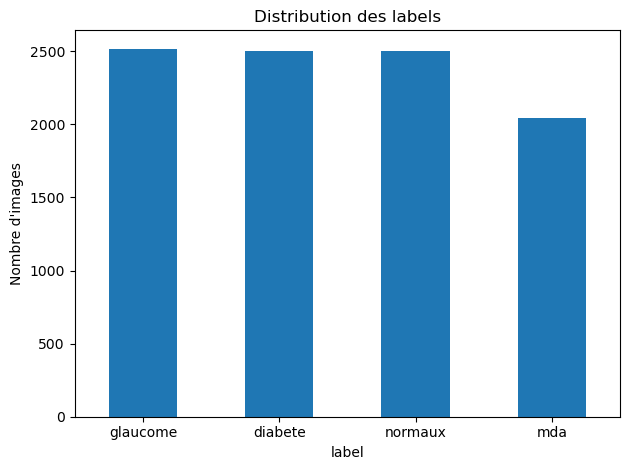

In [47]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Distribution des labels")
plt.xlabel("label")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [48]:
for classe in df['label'].unique():
    print(f"\nExemples pour la classe '{classe}' :")
    print(df[df['label'] == classe]['path'].head(3).tolist())



Exemples pour la classe 'glaucome' :
['E:\\mémoire\\Memoire\\data\\glaucome\\ACRIMA\\ACRIMA\\NOT PARTITIONED\\glaucoma\\Im310_g_ACRIMA.jpg', 'E:\\mémoire\\Memoire\\data\\glaucome\\ACRIMA\\ACRIMA\\NOT PARTITIONED\\glaucoma\\Im311_g_ACRIMA.jpg', 'E:\\mémoire\\Memoire\\data\\glaucome\\ACRIMA\\ACRIMA\\NOT PARTITIONED\\glaucoma\\Im312_g_ACRIMA.jpg']

Exemples pour la classe 'mda' :
['E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Dataset\\train\\amd\\1012.jpg', 'E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\\AMDNet23 Dataset\\train\\amd\\1013.jpg', 'E:\\mémoire\\Memoire\\data\\mda\\AMDNet23 Fundus Image Dataset for  Age-Related Macular Degeneration Disease Detection\

In [49]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)




print("Tailles des splits :")
print(f"Train : {len(df_train)}")
print(f"Test : {len(df_test)}")


Tailles des splits :
Train : 7650
Test : 1913


In [50]:
def show_distribution(name, data):
    print(f"\n{name}")
    print(data['label'].value_counts(normalize=True).round(3))

show_distribution("Train", df_train)
show_distribution("Test", df_test)



Train
label
glaucome    0.263
diabete     0.261
normaux     0.261
mda         0.214
Name: proportion, dtype: float64

Test
label
glaucome    0.263
normaux     0.261
diabete     0.261
mda         0.214
Name: proportion, dtype: float64


In [51]:
import cv2
import numpy as np
import os

def augment_image(img):
    aug_images = []

    # rotation
    for angle in [-15, 15]:
        h, w = img.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
        aug_images.append(cv2.warpAffine(img, M, (w, h)))

    # flip
    aug_images.append(cv2.flip(img, 1))

    return aug_images


In [52]:
from PIL import Image
import numpy as np

def load_image_gray(path):
    img = Image.open(path).convert("L")
    return np.array(img)

Version avec extraction de caracteristique


In [53]:
from skimage.feature import hog

def extract_hog(image):
    image = cv2.resize(image, (128, 128))
    features = hog(
        image,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys'
    )
    return features


In [54]:
X_train, y_train = [], []

for _, row in df_train.iterrows():
    img = load_image_gray(row['path'])

    # image originale
    X_train.append(extract_hog(img))
    y_train.append(row['label'])

    # data augmentation
    for aug in augment_image(img):
        X_train.append(extract_hog(aug))
        y_train.append(row['label'])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Train :", X_train.shape, y_train.shape)


Train : (30600, 8100) (30600,)


In [55]:
X_test, y_test = [], []

for _, row in df_test.iterrows():
    img = load_image_gray(row['path'])
    X_test.append(extract_hog(img))
    y_test.append(row['label'])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test :", X_test.shape, y_test.shape)


Test : (1913, 8100) (1913,)


In [58]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [60]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
lr = LogisticRegression(
    max_iter=5000,
    random_state=42
)

param_grid = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "tol": [1e-4, 1e-3, 1e-2],
        "max_iter": [2000, 5000]
    }
]

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    n_jobs=1,
    verbose=2
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.3min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.1min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.3min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.2min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time= 1.0min
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  21.5s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  24.9s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  22.7s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  22.7s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  20.9s
[CV] END C=0.001, max_iter=2000, penalty=l2

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"[{'C': [0.001, 0.01, ...], 'max_iter': [2000, 5000], 'penalty': ['l2'], 'solver': ['lbfgs'], ...}]"
,scoring,'f1_macro'
,n_jobs,1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [61]:
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score CV (F1-macro) :", grid.best_score_)
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test)


Meilleurs paramètres : {'C': 0.001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Meilleur score CV (F1-macro) : 0.7609486244698388


In [62]:
from sklearn.metrics import classification_report
print("\n===== Logistic Regression (Best Model) =====")
print(classification_report(y_test, y_pred))



===== Logistic Regression (Best Model) =====
              precision    recall  f1-score   support

     diabete       0.73      0.88      0.80       500
    glaucome       0.86      0.91      0.89       504
         mda       0.88      0.84      0.86       409
     normaux       0.62      0.47      0.54       500

    accuracy                           0.77      1913
   macro avg       0.77      0.78      0.77      1913
weighted avg       0.77      0.77      0.77      1913



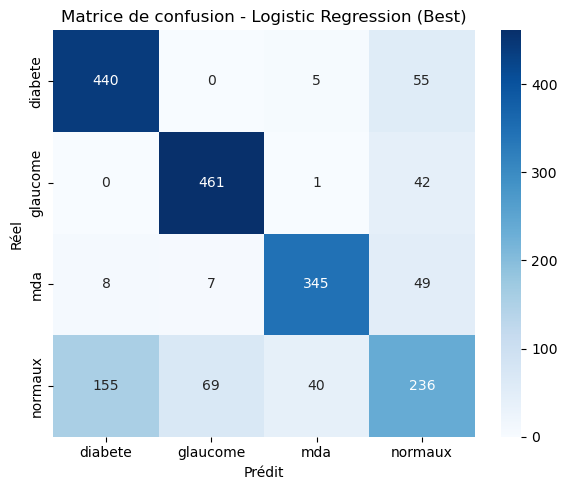

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred, labels=best_lr.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_lr.classes_,
    yticklabels=best_lr.classes_
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Logistic Regression (Best)")
plt.tight_layout()
plt.show()


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

acc = accuracy_score(y_test, y_pred)

prec_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
rec_macro  = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro   = f1_score(y_test, y_pred, average='macro', zero_division=0)

prec_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
rec_weighted  = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1_weighted   = f1_score(y_test, y_pred, average='weighted', zero_division=0)

print(f"Accuracy: {acc:.4f}")
print(f"Precision macro: {prec_macro:.4f} | weighted: {prec_weighted:.4f}")
print(f"Recall macro:    {rec_macro:.4f} | weighted: {rec_weighted:.4f}")
print(f"F1 macro:        {f1_macro:.4f} | weighted: {f1_weighted:.4f}")


Accuracy: 0.7747
Precision macro: 0.7721 | weighted: 0.7670
Recall macro:    0.7776 | weighted: 0.7747
F1 macro:        0.7703 | weighted: 0.7661


In [65]:
specificities = []

for i in range(len(best_lr.classes_)):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - (tp + fp + fn)

    spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(spec)

spec_macro = np.mean(specificities)

print(f"Specificity macro: {spec_macro:.4f}")
print("Specificity par classe:")
print(dict(zip(best_lr.classes_, specificities)))


Specificity macro: 0.9242
Specificity par classe:
{'diabete': 0.8846426043878273, 'glaucome': 0.9460610361958836, 'mda': 0.9694148936170213, 'normaux': 0.8966737438075018}


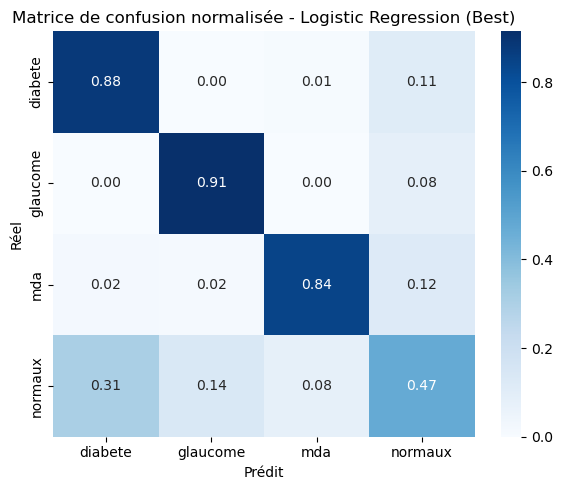

In [66]:
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=best_lr.classes_,
    yticklabels=best_lr.classes_
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion normalisée - Logistic Regression (Best)")
plt.tight_layout()
plt.show()


In [67]:
import joblib

joblib.dump(best_lr, "logistic_regression_best.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Meilleur modèle et scaler sauvegardés 💾")


Meilleur modèle et scaler sauvegardés 💾


Seulement PCA

In [68]:
def image_to_vector(image, size=(128, 128)):
    image = cv2.resize(image, size)
    return image.flatten()


In [69]:
X_train, y_train = [], []

for _, row in df_train.iterrows():
    img = load_image_gray(row["path"])

    # image originale
    X_train.append(image_to_vector(img))
    y_train.append(row["label"])

    # data augmentation
    for aug in augment_image(img):
        X_train.append(image_to_vector(aug))
        y_train.append(row["label"])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Train :", X_train.shape, y_train.shape)


Train : (30600, 16384) (30600,)


In [70]:
X_test, y_test = [], []

for _, row in df_test.iterrows():
    img = load_image_gray(row["path"])
    X_test.append(image_to_vector(img))
    y_test.append(row["label"])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test :", X_test.shape, y_test.shape)


Test : (1913, 16384) (1913,)


In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (95 % de variance conservée)
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

print("Pixels initiaux :", X_train_scaled.shape[1])
print("Dimensions après PCA :", X_train.shape[1])
print("Variance expliquée :", pca.explained_variance_ratio_.sum())


Pixels initiaux : 16384
Dimensions après PCA : 63
Variance expliquée : 0.950154290895372


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

lr = LogisticRegression(random_state=42)

param_grid = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": [0.001, 0.01, 0.1, 1, 10],
        "max_iter": [2000, 5000]
    }
]

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    verbose=2
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...C=0.001, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.5s
[CV] END ...C=0.001, max_iter=2000, penalty=l2, solver=lbfgs; total time=   4.9s
[CV] END ...C=0.001, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.0s
[CV] END ...C=0.001, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.6s
[CV] END ...C=0.001, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.4s
[CV] END ...C=0.001, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.7s
[CV] END ...C=0.001, max_iter=5000, penalty=l2, solver=lbfgs; total time=   5.0s
[CV] END ...C=0.001, max_iter=5000, penalty=l2, solver=lbfgs; total time=   5.0s
[CV] END ...C=0.001, max_iter=5000, penalty=l2, solver=lbfgs; total time=   5.8s
[CV] END ...C=0.001, max_iter=5000, penalty=l2, solver=lbfgs; total time=   5.4s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....C=0.01, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s
[CV] END ....C=0.01, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.3s
[CV] END ....C=0.01, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.8s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....C=0.01, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.4s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....C=0.01, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.4s
[CV] END ....C=0.01, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.2s
[CV] END ....C=0.01, max_iter=5000, penalty=l2, solver=lbfgs; total time=   5.2s
[CV] END ....C=0.01, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.2s
[CV] END ....C=0.01, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.0s
[CV] END ....C=0.01, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.4s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=0.1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.5s
[CV] END .....C=0.1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   4.9s
[CV] END .....C=0.1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.8s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=0.1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....C=0.1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.3s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   4.9s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   5.8s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.6s
[CV] END .....C=0.1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.4s
[CV] END .......C=1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.9s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.4s
[CV] END .......C=1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.1s
[CV] END .......C=1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   5.9s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=1, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s
[CV] END .......C=1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.0s
[CV] END .......C=1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.7s
[CV] END .......C=1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.1s
[CV] END .......C=1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.0s
[CV] END .......C=1, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.2s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=10, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=10, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.4s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=10, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.2s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=10, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=10, max_iter=2000, penalty=l2, solver=lbfgs; total time=   6.3s
[CV] END ......C=10, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.4s
[CV] END ......C=10, max_iter=5000, penalty=l2, solver=lbfgs; total time=   8.1s
[CV] END ......C=10, max_iter=5000, penalty=l2, solver=lbfgs; total time=   8.4s
[CV] END ......C=10, max_iter=5000, penalty=l2, solver=lbfgs; total time=   6.9s
[CV] END ......C=10, max_iter=5000, penalty=l2, solver=lbfgs; total time=   7.4s


c:\Users\mathi\anaconda3\envs\bigdatatp\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,estimator,LogisticRegre...ndom_state=42)
,param_grid,"[{'C': [0.001, 0.01, ...], 'max_iter': [2000, 5000], 'penalty': ['l2'], 'solver': ['lbfgs']}]"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [73]:
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score CV (F1-macro) :", grid.best_score_)
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test)


Meilleurs paramètres : {'C': 10, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs'}
Meilleur score CV (F1-macro) : 0.6835092623491633


In [74]:
print("\n===== Logistic Regression (Best Model) =====")
print(classification_report(y_test, y_pred))


===== Logistic Regression (Best Model) =====
              precision    recall  f1-score   support

     diabete       0.70      0.91      0.79       500
    glaucome       0.80      0.93      0.86       504
         mda       0.77      0.70      0.73       409
     normaux       0.49      0.29      0.37       500

    accuracy                           0.71      1913
   macro avg       0.69      0.71      0.69      1913
weighted avg       0.69      0.71      0.69      1913



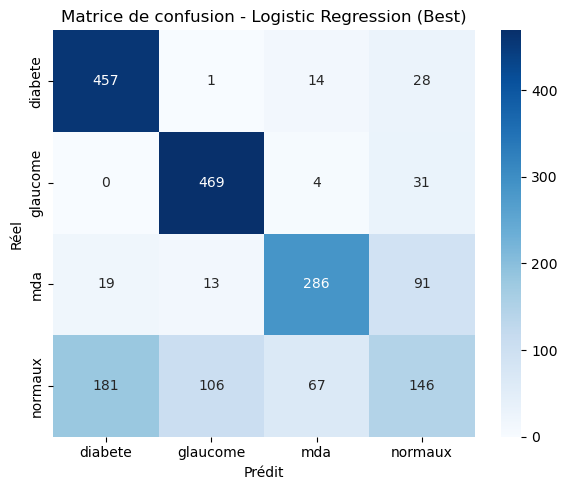

In [75]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred, labels=best_lr.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_lr.classes_,
    yticklabels=best_lr.classes_
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Logistic Regression (Best)")
plt.tight_layout()
plt.show()


PCA + extraction de données

In [76]:
X_train, y_train = [], []

for _, row in df_train.iterrows():
    img = load_image_gray(row["path"])

    # image originale
    X_train.append(extract_hog(img))
    y_train.append(row["label"])

    # data augmentation
    for aug in augment_image(img):
        X_train.append(extract_hog(aug))
        y_train.append(row["label"])

X_train = np.array(X_train)
y_train = np.array(y_train)

print("Train :", X_train.shape, y_train.shape)


Train : (30600, 8100) (30600,)


In [77]:
X_test, y_test = [], []

for _, row in df_test.iterrows():
    img = load_image_gray(row["path"])
    X_test.append(extract_hog(img))
    y_test.append(row["label"])

X_test = np.array(X_test)
y_test = np.array(y_test)

print("Test :", X_test.shape, y_test.shape)


Test : (1913, 8100) (1913,)


In [78]:
# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA (95 % de variance conservée)
pca = PCA(n_components=0.95, random_state=42)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)

print("Dimensions HOG initiales :", X_train_scaled.shape[1])
print("Dimensions après PCA :", X_train.shape[1])
print("Variance expliquée :", pca.explained_variance_ratio_.sum())


Dimensions HOG initiales : 8100
Dimensions après PCA : 1758
Variance expliquée : 0.9500556867420561


In [79]:
lr = LogisticRegression(random_state=42)

param_grid = [
    {
        "solver": ["lbfgs"],
        "penalty": ["l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100],
        "tol": [1e-4, 1e-3, 1e-2],
        "max_iter": [2000, 5000]
    }
]

grid = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring="f1_macro",
    cv=5,
    verbose=2
)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  17.2s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  18.9s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  15.8s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  18.5s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.0001; total time=  18.0s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=   9.0s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  10.1s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  10.4s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  11.1s
[CV] END C=0.001, max_iter=2000, penalty=l2, solver=lbfgs, tol=0.001; total time=  10.4s
[CV] END C=0.001, max_iter=2000, penalty=l2

,estimator,LogisticRegre...ndom_state=42)
,param_grid,"[{'C': [0.001, 0.01, ...], 'max_iter': [2000, 5000], 'penalty': ['l2'], 'solver': ['lbfgs'], ...}]"
,scoring,'f1_macro'
,n_jobs,None
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [80]:
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score CV (F1-macro) :", grid.best_score_)
best_lr = grid.best_estimator_
y_pred = best_lr.predict(X_test)

Meilleurs paramètres : {'C': 0.001, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.01}
Meilleur score CV (F1-macro) : 0.7551718131513607


In [81]:
print("\n===== Logistic Regression (Best Model) =====")
print(classification_report(y_test, y_pred))


===== Logistic Regression (Best Model) =====
              precision    recall  f1-score   support

     diabete       0.73      0.89      0.80       500
    glaucome       0.86      0.92      0.89       504
         mda       0.86      0.83      0.85       409
     normaux       0.62      0.46      0.53       500

    accuracy                           0.77      1913
   macro avg       0.77      0.77      0.76      1913
weighted avg       0.76      0.77      0.76      1913



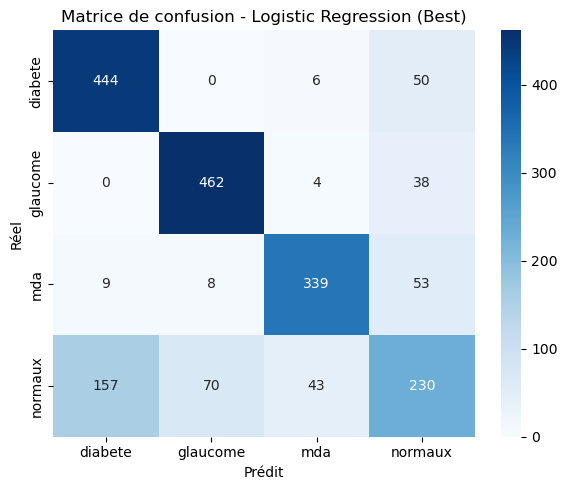

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(y_test, y_pred, labels=best_lr.classes_)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=best_lr.classes_,
    yticklabels=best_lr.classes_
)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Logistic Regression (Best)")
plt.tight_layout()
plt.show()
